# Levenberg-Marquardt algorithm: determination of a quasi-periodic orbit around L2
## Objectives

This is a minimal working example of the Levenberg-Marquardt algorithm for the transition of an L2 Halo orbit from the Circular Restricted Three-Body Problem (CR3BP) to a high-fidelity ephemeris model (HFEM) considering the point-mass influences of the Earth, Moon, and Sun, whose motion is modeled via planetary ephemerides information, retrieved via the <a href="https://docs.tudat.space/en/latest/" target="_blank">TU Delft's Astrodynamics Toolbox (TUDAT)</a>. *Note that this example considers only a baseline version of the LM algorithm and may thus stall under inadequate conditions, namely a demanding proximity constraint. A more complete version, with the possibility for adaptive weighting in the optimization problem formulation, is provided in the alternative [L2_L1_transfer](L2_L1_Transfer.ipynb) example.*

The CR3BP initial guess considered in this example has been retrieved from the extensive <a href="https://ssd.jpl.nasa.gov/tools/periodic_orbits.html" target="_blank">NASA JPL Three-Body Periodic orbits catalog</a>. This orbit is enconded in the [L2_Halo_pp.txt](CR3BP_files/L2_Halo_pp.txt) file, where the information regarding 10 revolutions-worth of patch points is available, considering 4 patch points per orbit.

In this notebook, it is possible to select the transition algorithm employed, such that the proposed LM implementation may compared with the minimum-norm update equation typically found in literature.

## Pre-Requisites
Note that this example will assume that the user is familiar with the general propoagation functionalities of Tudat, with minimal comments on the corresponding function calls. An introduction to this package, with beginnger and advanced examples, is available <a href="https://docs.tudat.space/en/latest/examples/propagation.html" target="_blank">here</a>.

## Import Statements
We initially import the necessary modules, starting with standard libraries such as `math`, `numpy`, `matplotlib` and some directories from `scipy`. Necessary `tudatpy`modules are also imported. In addition, some auxiliary functions and classes are loaded from the auxiliary [utility file](utils.py), whose definition is omitted in this example for the sake of conciseness.

In [1]:
# Load standard modules
import math
import numpy as np
import matplotlib

%matplotlib widget
from matplotlib import pyplot as plt
from matplotlib import ticker
from scipy.integrate import solve_ivp
from scipy.optimize._numdiff import approx_derivative
from scipy.interpolate import interp1d

# Load tudatpy modules
from tudatpy.interface import spice
from tudatpy import numerical_simulation
from tudatpy.numerical_simulation import environment
from tudatpy.numerical_simulation import environment_setup, propagation_setup
from tudatpy.astro import element_conversion
from tudatpy import constants
from tudatpy.util import result2array
from tudatpy.astro.time_conversion import DateTime

# Load auxiliary functions
from utils import *

## Scaling factors and simulation start epoch
A set of scale factors for length, time, velocity, and acceleration quantities are established. In this example, the Earth-Moon characteristic length and time, retrieved from the previous <a href="https://ssd.jpl.nasa.gov/tools/periodic_orbits.html" target="_blank">NASA JPL Three-Body Periodic orbits catalog</a>, are considered and used for the computation of the remaining scales.

The start epoch considered for simulation is also set, without loss of generality, to the 1st of January, 2020.

In [2]:
# Define characteristic scales
L_SCALE = 389703.0*1000 #m
T_SCALE = 382981.0 #s
V_SCALE = L_SCALE/T_SCALE
A_SCALE = V_SCALE/T_SCALE

# Establish the simulation start epoch
simulation_start_epoch = DateTime(2020, 1, 1).epoch()

## Environment setup
To setup the environment, we start by loading the NAIF spice kernels. In this example, the HFEM dynamics are built considering the gravitational influence of the Sun, Earth, and Moon, modelled as point-masses. The dynamics are established under the J2000 inertial frame, centered at the Earth. The satellite body is also created for propagation, considering celestial bodies' gravitational forces.

In [3]:
# Load spice kernels
spice.load_standard_kernels()

# Define bodies to be created from default settings
bodies_to_create = ["Earth", "Moon", "Sun"]

# Use "Earth"/"J2000" as global frame origin and orientation
global_frame_origin = "Earth"
global_frame_orientation = "J2000"

# Create default body settings
body_settings = environment_setup.get_default_body_settings(
    bodies_to_create,
    global_frame_origin,
    global_frame_orientation)

# Retrieve Earth and Moon gravitational parameters for future use (dimensionless)
mu_e = body_settings.get("Earth").gravity_field_settings.gravitational_parameter/(L_SCALE**3)*T_SCALE**2
mu_m = body_settings.get("Moon").gravity_field_settings.gravitational_parameter/(L_SCALE**3)*T_SCALE**2

# Sun requires manual definition of gravitational parameter (dimensional) from spice data
body_settings.get("Sun").gravity_field_settings = environment_setup.gravity_field.central( spice.get_body_gravitational_parameter("Sun") )

# Create a Satellite body with empty settings
body_settings.add_empty_settings("Satellite")

# Create the system of bodies
bodies = environment_setup.create_system_of_bodies(body_settings)

# Define central bodies for propagation
central_bodies = [global_frame_origin]

# Define satellite body, whose dynamics are going to be propagated
bodies_to_propagate = ["Satellite"]

# Define accelerations acting on Satellite by celestial bodies, modelled as point-masses
accelerations_settings_sat= dict(
    Earth=[
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Moon=[
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Sun=[
        propagation_setup.acceleration.point_mass_gravity()
    ],
)

# Create global accelerations settings dictionary
acceleration_settings = {"Satellite": accelerations_settings_sat}

# Create acceleration models
acceleration_models = propagation_setup.create_acceleration_models(
    bodies,
    acceleration_settings,
    bodies_to_propagate,
    central_bodies)


## Integrator settings
The settings for the propagation of the dynamics are established, namely the integrator to be used, the step size control settings and the integration tolerance. *Note that tightening the integration tolerance or decreasing the maximum step size may lead to a significant increase in the computation time over the following code.*

In [4]:

# Create numerical integrator settings
min_step_size = 0.0001 # minimum step-size
max_step_size = 1000.0 # maximum step-size
initial_step = 50 # initial step-size
int_tolerance = 1.0E-8 # integration tolerance

# Create integrator tolerance settings
int_control_settings = propagation_setup.integrator.step_size_control_elementwise_scalar_tolerance(
    int_tolerance,
    int_tolerance
)

# Create step-size validation settings
int_validation_settings = propagation_setup.integrator.step_size_validation(
    min_step_size,
    max_step_size
)

# Create numerical integrator with proposed settings, considering Runge-Kutta-Fehlberg method of order 7(8)
integrator_settings = propagation_setup.integrator.runge_kutta_variable_step(
    initial_time_step=initial_step,
    coefficient_set=propagation_setup.integrator.CoefficientSets.rkf_78,
    step_size_control_settings = int_control_settings,
    step_size_validation_settings = int_validation_settings
)

## Initialization
The CR3BP orbit, whose patch points and corresponding relative time instants may be found in [L2_Halo_pp.txt](CR3BP_files/L2_Halo_pp.txt) file, is retrieved. The time quantities are adjusted to achieve an accurate correspondence between the description of the synodifc frame under the CR3BP and HFEM. Similarly, the nondimensional states under the synodic frame of the CR3BP are transformed into the J2000 inertial frame. This requires the use of the auxiliary `FrameConverter` class and several function defined in the auxiliary [utility file](utils.py).

In [5]:
# Open file containing nominal CR3BP trajectory information
with open("CR3BP_files/L2_Halo_pp.txt", "r") as data:
    lines = data.readlines()

# Store the CR3BP states and corresponding time instants
t_nom_pp = []
q_nom_pp = []
for line in lines:
    x, y1, y2, y3, y4, y5, y6 = line.split()
    t_nom_pp.append(float(x)/T_SCALE)

    q_nom_pp.append(([float(y1), float(y2), float(y3), float(y4), float(y5), float(y6)]))

t_nom_pp = np.array(t_nom_pp)
q_nom_pp = np.array(q_nom_pp)

# Correct the CR3BP time instants for time dilation/contraction effects between the two models
t_nom_corr = []
t_nom_corr.append(simulation_start_epoch)
for t in t_nom_pp[1::]:
    solution = solve_ivp(
                integrate_time,
                t_span= [0, t],
                y0 = [0],
                t_eval = np.linspace(0, t, num=2),
                method ='DOP853',
                max_step = t/100,
                first_step = t/1000,
                atol = int_tolerance,
                args = (simulation_start_epoch,
                        global_frame_origin,
                        global_frame_orientation,
                        mu_e,
                        mu_m,
                        T_SCALE,
                        L_SCALE),
            )
    t_aux = solution.y.T[-1]
    t_corr = t_aux[0]
    t_nom_corr.append(t_corr*T_SCALE+simulation_start_epoch) 

t_nom_pp = np.array(t_nom_corr) # Update nominal orbit instants

# Simulation end epoch corresponds to last corrected time instant
simulation_end_epoch = t_nom_pp[-1]

# State transformation
t_vec = []
q_vec = []
i=0
for t, q in zip(t_nom_pp, q_nom_pp):
    converter = FrameConverter(
                    t,
                    mu_e,
                    mu_m,
                    global_frame_origin,
                    global_frame_orientation,
                    body_settings,
                    L_SCALE,
                    T_SCALE,
                    V_SCALE
                )
    q_vec.append(converter.CR3BP_to_J2000_inertial(q))
    t_vec.append(t/T_SCALE)

    i=i+1

# Update to numpy arrays
q_vec = np.array(q_vec)
t_vec = np.array(t_vec)

# Construction of initial guess from transformed data, and corresponding time instants
X_init = np.array(q_vec.flatten())
T_init = t_vec

# Calculate number of patch points
N_pp = int(np.size(T_init))

## `AlgorithmSettings` Class

We define an auxiliary class to store the necessary settings for the operation of the algorithms employed. These correspond to general settings that both algorithms require, and specific parameters that are particular to the LM algorithm. A set of default settings is provided.

> ### General parameters:
> - **max_it : *int, optional***\
Maximum number of (outer) iterations. If the algorithm is unable to converge before the number of iterations reaches this value, the algorithm is automatically stopped. Default is 25.
> - **abs_tol : *float, optional***\
Absolute tolerance for algorithm termination. If the continuity residual falls below this value, the algorithm is terminated. Default is 1e-12.
>
> - **rel_tol : *float, optional***\
Relative tolerance for algorithm termination. If the relative difference between consecutive values of the continuity residual falls below this value the algorithm is assumed to have converged or stalled, and hence is terminated. Default is 1e-6.

> ### LM-specific parameters:
>
> - **Q : *array_like, optional***\
Proximity weight matrix. Weighs proximity of the design vector to the initial conditions. Default is None, i.e. a matrix filled with zeros.
> - **beta_start : *float, optional***\
Initial value for the LM update step damping term. Default value is 1e-5.
> - **alpha : *float, optional***\
LM update step damping term decrease factor for successful update steps. Default value is 0.7.
> - **eta : *float, optional***\
LM update step damping term increase factor for unsuccessful update steps. Default value is 1.2.
> - **max_it_in : *int, optional***\
Maximum number of inner LM iterations. If the number of inner LM iterations, i.e. those necessary to achieve a successful step, goes past this threshold, the algorithm is terminated (likely converged/stalled) and a warning message is provided. Default value is 100.


In [6]:
class AlgorithmSettings:
    def __init__(self, max_it = 25, abs_tol = 1e-12, rel_tol = 1e-6, Q=None, beta_start = 1e-5, alpha = 0.7, eta = 1.5, max_it_in = 100):

        # General parameters
        self.max_it = max_it
        self.abs_tol = abs_tol
        self.rel_tol = rel_tol

        # LM parameters
        self.Q = Q
        self.beta_start = beta_start
        self.alpha = alpha
        self.eta = eta
        self.max_it_in = max_it_in


algorithm_settings = AlgorithmSettings() # Use default settings

## `Algorithm` Class
Auxiliary class to initialize the algorithm to be used with the established settings. *Here, you may change what algorithm is used to later solve the optimization problem.*

> ### Parameters:
>
> - **method : *{"MN", "LM"}***\
("MN", "LM") Algorithm to be used when solving the optimization problem, i.e. "MN" for minimum-norm update equation or "LM" for Levenberg-Marquardt algorithm.
> - **X0 : *array_like***\
Initial (dimensionless) design vector.
> - **T : *array_like***\
Initial (dimensionless) epochs.
> - **bodies : *SystemOfBodies (tudat-space)***\
System of bodies considered in the simulation.
> - **global_frame_origin : *string***\
Origin of the dynamics being propagated.
> - **settings : *AlgorithmSettings***\
Set of algorithm settings, a class defined above.

> ### Functions:
>
> - **`solve_OP()`**\
Solves the optimization problem with the established settings and slected method. Runs outer iterations to compute the update step and update the continuity residual until any stop criteria is reached. If Levenberg-Marquardt method is being used, inner iterations run until a successful step is found or the maximum number of inner iterations is reached.
> - **`get_objective_jacobian()`**\
Computes the objective function and Jacobian of the optimization problem, using State-Transtition Matrix (STM) information, for use in the `solve_OP()` function.
> - **`STM_deriv()`**\
Computes derivative of the STM, under a linear approximation of the dynamics, for use in the `get_objective_jacobian()` function.
> - **`get_A()`**\
Computes linear approximation of the dynamics, for use in the `STM_deriv()` function.

In [7]:
######## Algorithm Class ########
class Algorithm:
    def __init__(self, method: str, X0, T, bodies, global_frame_origin, settings: AlgorithmSettings):

        # Store method, initial guess, epochs, settings, and other info
        self.method = method
        self.X0 = X0
        self.T = T
        self.N = int(np.size(T))
        self.settings = settings

        # Build current iteration of design vector
        self.Xk = X0.copy()

        # Create the list of relevant bodies
        self.bodies = bodies
        self.list_bodies = bodies.list_of_bodies().copy()

        # Remove auxiliary bodies and central body from list of bodies (relevant for the computation of the Jacobian)
        if "Satellite" in self.list_bodies: self.list_bodies.remove("Satellite")
        if "EarthMoonBarycenter" in self.list_bodies: self.list_bodies.remove("EarthMoonBarycenter")
        if global_frame_origin in self.list_bodies: self.list_bodies.remove(global_frame_origin)

    # Function to solve the optimization problem with the established settings
    def solve_OP(self):

        # General initializations
        I = np.eye(6*self.N) # Identity matrix
        # Weight matrix
        if self.settings.Q is None:
            Q = np.zeros((6*self.N,6*self.N))
        else:
            Q = self.settings.Q

        # General algorithm settings
        max_it = self.settings.max_it
        abs_tol = self.settings.abs_tol
        rel_tol = self.settings.rel_tol

        # LM algorithm settings
        beta = self.settings.beta_start
        alpha = self.settings.alpha
        eta = self.settings.eta
        max_it_in = self.settings.max_it_in

        # Initial value of the objective function and Jacobian
        Fk, DFk = self.get_objective_and_jacobian(self.Xk, self.T, return_jac=True)
        # Store initial continuity residual
        Fk_norm = np.linalg.norm(Fk)

        # Display starting information
        print("Starting algorithm: ||F|| = %.6E" % (Fk_norm))

        # Start iteration counter
        it = 0
        while True:

            # Update iteration number
            it = it+1

            # Evaluate chosen method
            if self.method == "MN": # minimum-norm
                # Compute minimum-norm update step
                DXk = -DFk.T@(np.linalg.inv(DFk@DFk.T))@Fk
                self.Xk = self.Xk + DXk

            elif self.method == "LM": # Levenberg-Marquardt

                # Current error with respect to initial conditions

                Ek = self.Xk - self.X0
                # Start inner iteration counter
                it_in = 0 

                while True:
                    # Update inner iteration number
                    it_in = it_in + 1

                    # Compute LM update step
                    DXk = - np.linalg.inv( DFk.T@DFk + Q + beta*I )@ ( (DFk.T)@Fk + Q@Ek)

                    # Apply update step for testing through auxiliary variables
                    X_try = self.Xk + DXk
                    F_try = self.get_objective_and_jacobian(X_try, self.T, return_jac=False)
                    
                    # Test update step
                    if(np.linalg.norm(F_try)<Fk_norm):
                        # Successful, decrease damping factor, update true design vector, and exit inner iterations
                        beta = beta * alpha
                        self.Xk = X_try
                        break
                    else:
                        # Unsucessful, exit if maximum number of inner iterations has been reached
                        if(it_in>=max_it_in):
                            print("Maximum number of inner LM iterations reached")
                            break
                        # or increase damping factor for next iteration
                        beta = beta * eta
            else:
                # Error if method is not MN or LM
                ValueError("Method has to be either MN or LM")

            # Store previous continuity residual value
            Fk_norm_prev = Fk_norm

            # Compute new objective function and Jacobian values from updated step
            Fk, DFk = self.get_objective_and_jacobian(self.Xk, self.T, return_jac=True)
            # Compute new continuity residual
            Fk_norm = np.linalg.norm(Fk)

            # Display iteration information
            print("Iteration number %d: ||F|| = %.6E" % (it, Fk_norm))

            # Exit if maximum number of iterations has been reached
            if(it>=max_it):
                print("Maximum number of iterations reached")
                break
            
            # Exit if continuity residual is within the desired absolute/relative tolerances
            if(Fk_norm<abs_tol):
                print("Absolute tolerance reached")
                break
            elif(np.abs(Fk_norm-Fk_norm_prev)/Fk_norm_prev<rel_tol):
                print("Relative tolerance reached")
                break

            # Continue to next iteration if otherwise

        # Return the final solution, iteration number, and continuity residual
        return self.Xk, it, Fk_norm

        
    # Function to retrieve the objective function and Jacobian of the optimization problem
    def get_objective_and_jacobian(self,X,T,return_jac = False):
        
        # Initialization
        F = []

        if return_jac:
            DF = np.zeros((6*(self.N-1),6*self.N))

        # Retrieve relevant quantities into more adequate shapes
        q_vec = X.copy().reshape((self.N,6))
        tau_vec = T

        for i in range(0,self.N-1):
            q_i = q_vec[i,:]
            tau_i = tau_vec[i]
            tau_f = tau_vec[i+1]

            # Integrate between tau_i and tau_f using dimensional quantities
            t_dim,q_dim = integrate_dynamics(
                np.concatenate((q_i[0:3]*L_SCALE, q_i[3:6]*V_SCALE)),
                tau_i*T_SCALE,
                tau_f*T_SCALE,
                central_bodies,
                acceleration_models,
                bodies_to_propagate,
                integrator_settings,
                bodies
            )

            # Retrieve dimensionless spacecraft states from integrated segment
            r_sat = q_dim[:,0:3]/L_SCALE
            v_sat = q_dim[:,3:6]/V_SCALE
            q = np.concatenate((r_sat,v_sat),axis=1)
            t = t_dim/T_SCALE
            q_f = q[-1]

            # Append the current coninuity constraint entry
            F.append(q_f-q_vec[i+1,:])

            if return_jac:
                # Define Look Up Table for integrated trajectory segment
                q_sat_lut = interp1d(t, q, kind='linear', axis=0, bounds_error=False, fill_value="extrapolate")

                # Integrate Phi and dx/dtau using the integrated trajectory segment information
                solution = solve_ivp(
                    self.STM_deriv,
                    t_span= [tau_i, tau_f],
                    y0 = np.eye(6).reshape(-1),
                    t_eval = np.linspace(tau_i, tau_f, num=2),
                    method ='DOP853',
                    max_step = (tau_f-tau_i)/10,
                    first_step = (tau_f-tau_i)/100,
                    atol = int_tolerance,
                    args = (q_sat_lut,)
                )
                
                # Retrieve final STM
                y = solution.y.T[-1]
                phi = y.reshape((6,6))

                DF[6*i:6*(i+1), 6*i:6*(i+1)] = phi # d (x^t_i+1) / d x_i
                DF[6*i:6*(i+1), 6*(i+1):6*(i+2)] = -np.eye(6) # d (-x_i) / d x_i


        F = np.array(F).flatten()

        if return_jac:
            return F, DF
        else:
            return F
    
    # Function to retrieve the derivative of the STM for integration in the determination of the optimization problem's Jacobian
    def STM_deriv(self,t,y,q_sat_lut):

        # Retrieve spacecraft state from look-up table
        q_sat = q_sat_lut(t)

        # Calculate linear approximation of the dynamics, through get_A() function
        A = self.get_A(q_sat,t)

        # Reshape STM from flattened array
        Phi = y.reshape(6,6)

        # Calculate derivative of the STM
        dPhi_dt = A@Phi

        # Return flattened STM derivative
        return dPhi_dt.flatten()

    # Function to calculate the linear approximation of the dynamics for use in the integration of the STM
    def get_A(self, q_sat, t):

        # Retrieve spacecraft position vector and its norm
        r_sat = q_sat[0:3]
        r_i = np.linalg.norm(r_sat)

        # Initialize linear approximation matrix
        A = np.zeros((6,6))
        A[0:3,3:6] = np.eye(3)

        # Retrieve central body gravitational parameter, ensuring it is nondimensional
        CB_mu = body_settings.get(global_frame_origin).gravity_field_settings.gravitational_parameter/(L_SCALE**3)*(T_SCALE**2)
        # Compute the central body contribution to lower-left 3x3 submatrix (denoted A_star)
        A_star = CB_mu*( 3/(r_i**5)*np.outer(r_sat,r_sat) - 1/(r_i**3)*np.eye(3))

        # Iterate for the contributions of the remaining celestial bodies
        for body in self.list_bodies:
            # Retrieve celestial body gravitational parameter, ensuring it is nondimensional
            body_mu = body_settings.get(body).gravity_field_settings.gravitational_parameter/(L_SCALE**3)*(T_SCALE**2)

            # Retrieve celestial body position relative to central body
            r_body = spice.get_body_cartesian_position_at_epoch(
                target_body_name=body,
                observer_body_name=global_frame_origin,
                reference_frame_name=global_frame_orientation,
                aberration_corrections="NONE",
                ephemeris_time=t*T_SCALE,
            )
            # Ensure position is nondimensional
            r_body = r_body/L_SCALE
            # Compute relative position vector from spacecraft to the celestial body, and its norm
            r_body_sat = r_body-r_sat
            r_ij = np.linalg.norm(r_body_sat)

            # Compute the celestial body contribution to lower-left 3x3 submatrix (denoted A_star)
            A_star = A_star + body_mu*( 3/(r_ij**5)*np.outer(r_body_sat,r_body_sat) - 1/(r_ij**3)*np.eye(3))

        # Update linear approximation matrix with information in A_star
        A[3:6,0:3] = A_star

        # Return final approximation matrix
        return A
    
# Create the algorithm, selecting the method to be used
algorithm = Algorithm(
    method="LM", # CHANGE METHOD HERE
    X0 = X_init,
    T = T_init,
    bodies = bodies, 
    global_frame_origin = global_frame_origin,
    settings = algorithm_settings
)

## Solve Optimization Problem

It is now possible to solve the optimization problem using the algorithm selected, according to the set of settings previously defined. The program outputs the continuity residual at each iteration to accompany/inspect its execution.

> Note that, depending on the available resources of the platform where the code is being executed, this step may take a considerable amount of time.

In [8]:
# Solve the optimization problem with the established method and corresponding settings
Xf, it_num, F_norm = algorithm.solve_OP()

# Retrieve spacecraft states at each patch point of the converged solution
q_final_pp = Xf.copy().reshape((N_pp,6))

Starting algorithm: ||F|| = 5.104676E-02
Iteration number 1: ||F|| = 9.721528E-04
Iteration number 2: ||F|| = 8.934812E-06
Iteration number 3: ||F|| = 6.755427E-10
Iteration number 4: ||F|| = 9.349269E-13
Absolute tolerance reached


## Plot Results

In order to visualize the results, we will be transforming the final converged solution into the synodic reference frame. To improve the visualization, not only are the patch points transformed but also the trajectory segments in-between, which are integrated beforehand.

In [ ]:
# Initialize the arrays to store the final solution under the synodic reference frame
q_final_syn_pp = []
q_final_syn_full = []

# Iterate for all final solution patch points
for i in range(0,N_pp):
    q_i = q_final_pp[i,:]
    t_i = T_init[i]

    # Establish converter at current epoch (dimensional)
    converter = FrameConverter(
                    t_i*T_SCALE, 
                    mu_e, 
                    mu_m, 
                    global_frame_origin, 
                    global_frame_orientation, 
                    body_settings, 
                    L_SCALE,T_SCALE,
                    V_SCALE
                )
    
    # Append current transformed patch point
    q_final_syn_pp.append(converter.J2000_inertial_to_CR3BP(np.array(q_i[0:3])))

    # For all intermediate patch points
    if(i<N_pp-1):
        t_f = T_init[i+1]
        
        # Integrate between tau_i and tau_f, to retrieve full trajectory segment
        t_dim,q_dim = integrate_dynamics(
                        np.concatenate((q_i[0:3]*L_SCALE, q_i[3:6]*V_SCALE)),
                        t_i*T_SCALE,
                        t_f*T_SCALE,
                        central_bodies,
                        acceleration_models,
                        bodies_to_propagate,
                        integrator_settings,
                        bodies
                    )
        
        # Iterate over segment, being careful to avoid repeating states at the end and start of succeeding segments
        for t_ii,q_ii in zip(t_dim[0:-1], q_dim[0:-1,:]): 
            converter = FrameConverter(
                            t_ii, 
                            mu_e, 
                            mu_m, 
                            global_frame_origin, 
                            global_frame_orientation, 
                            body_settings, 
                            L_SCALE,
                            T_SCALE,
                            V_SCALE
                        )
            # Store the full trajectory segment
            q_final_syn_full.append(converter.J2000_inertial_to_CR3BP(q_ii[0:3]/L_SCALE))

# Update to numpy arrays
q_final_syn_pp = np.array(q_final_syn_pp)
q_final_syn_full = np.array(q_final_syn_full)

In addition, we retrieve the full CR3BP solution from the [L2_Halo_full.txt](CR3BP_files/L2_Halo_full.txt) file.

In [10]:
# Store full initial (CR3BP) solution
with open("CR3BP_files/L2_Halo_full.txt", "r") as data:
    lines = data.readlines()
q_nom_full = []
for line in lines:
    x, y1, y2, y3, y4, y5, y6 = line.split()
    q_nom_full.append(([float(y1), float(y2), float(y3), float(y4), float(y5), float(y6)]))

# Update to np array
q_nom_full=np.array(q_nom_full)

Finally, an interactive figure may be created and the corresponding trajectories plotted.

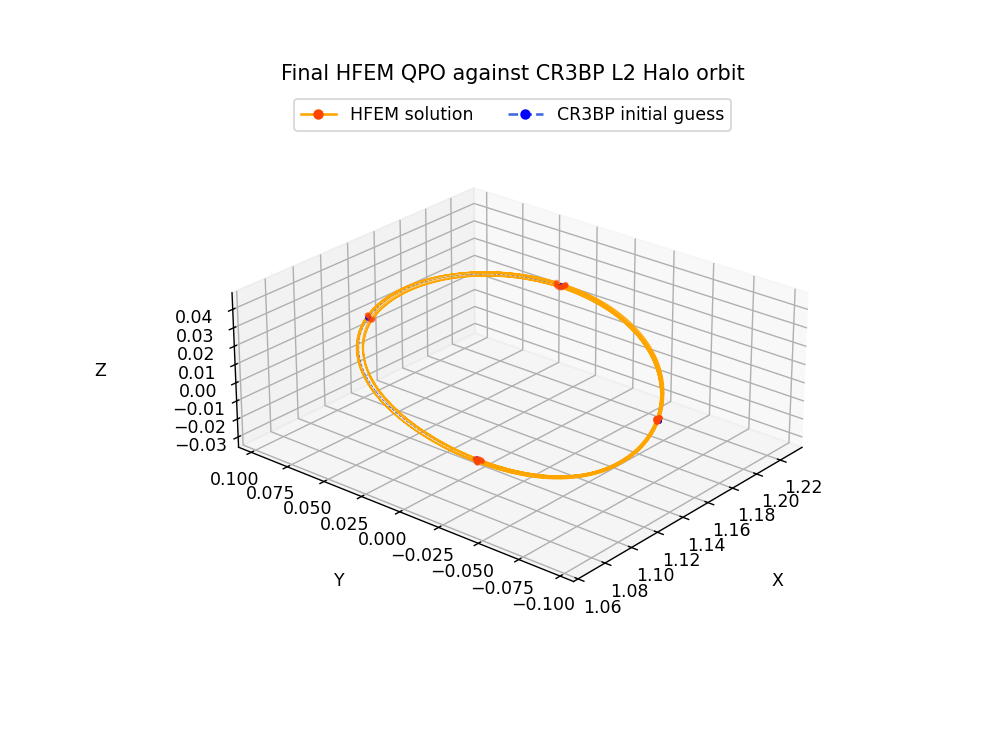

In [11]:
# Create figure and add axes
fig = plt.figure(figsize=(8,6), dpi=125)
ax = fig.add_subplot(111, projection='3d')

# Plot nominal orbit
ax.plot(q_nom_full[:, 0], q_nom_full[:, 1], q_nom_full[:, 2], linestyle='--', color='royalblue',linewidth=0.5)
ax.scatter(q_nom_pp[:, 0], q_nom_pp[:, 1], q_nom_pp[:, 2], marker='o', color='blue',s=5)

# Plot converged trajectory
ax.plot(q_final_syn_full[:, 0], q_final_syn_full[:, 1], q_final_syn_full[:, 2], linestyle='-', color='orange', linewidth=0.5)
ax.scatter(q_final_syn_pp[:, 0], q_final_syn_pp[:, 1], q_final_syn_pp[:, 2], marker='o', s=5, color='orangered')

# Auxiliary empty plots for the purposes of creating the legend
ax.plot(np.nan, np.nan, np.nan, color="orange", marker="o", markerfacecolor="orangered", markeredgecolor="none", linestyle="-",label="HFEM solution")
ax.plot(np.nan, np.nan, np.nan, color="royalblue", marker="o", markerfacecolor="blue", markeredgecolor="none", linestyle="--",label="CR3BP initial guess")

# Create the legend
ax.legend(loc='upper center', ncol=2)

# Axis labels and adjustments
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.xaxis.labelpad = 20  # increase space between x-axis and label
ax.yaxis.labelpad = 20
ax.zaxis.labelpad = 20

# Axis limits, aspect ratio, and view angle
ax.axis('tight')
ax.set_xlim((0.95*np.min(q_final_syn_full[:,0]),1.05*np.max(q_final_syn_full[:,0])))
ax.set_aspect('equal', adjustable='box')
ax.view_init(azim=-90-50, elev=25, roll=0)

# Set title
plt.title("Final HFEM QPO against CR3BP L2 Halo orbit")

# Display plot
plt.show()